# Carotid artery segmentation
This section demonstrates how to use the `CarotidSegmenter` model from the `zea` library to segment the carotid artery in ultrasound images. The model predicts a mask highlighting the carotid region for a given input image.

For more details, see the [original paper](https://doi.org/10.1016/j.cmpb.2022.107037):  
- Luuk van Knippenberg, "Unsupervised domain adaptation method for segmenting cross-sectional CCA images", Computers in Biology and Medicine, 2022.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tue-bmd/zea/blob/main/docs/source/notebooks/models/carotid_segmentation_example.ipynb)
&nbsp;
[![View on GitHub](https://img.shields.io/badge/GitHub-View%20Source-blue?logo=github)](https://github.com/tue-bmd/zea/blob/main/docs/source/notebooks/models/carotid_segmentation_example.ipynb)
&nbsp;
[![Hugging Face model](https://img.shields.io/badge/Hugging%20Face-Model-yellow?logo=huggingface)](https://huggingface.co/zeahub/carotid-segmenter)

In [ ]:
%%capture
%pip install zea

In [2]:
import os

# NOTE: should be `tensorflow` or `jax` for EchoNetDynamic
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import matplotlib.pyplot as plt
from keras import ops
from PIL import Image
import numpy as np
import requests
from io import BytesIO

from zea import init_device, log
from zea.tools.selection_tool import add_shape_from_mask
from zea.visualize import set_mpl_style

init_device(verbose=False)
set_mpl_style()

In [3]:
from zea.models.carotid_segmenter import CarotidSegmenter

presets = list(CarotidSegmenter.presets.keys())
log.info(f"Available built-in zea presets for CarotidSegmenter: {presets}")

model = CarotidSegmenter.from_preset("carotid-segmenter")

zea: Available built-in zea presets for CarotidSegmenter: ['carotid-segmenter']


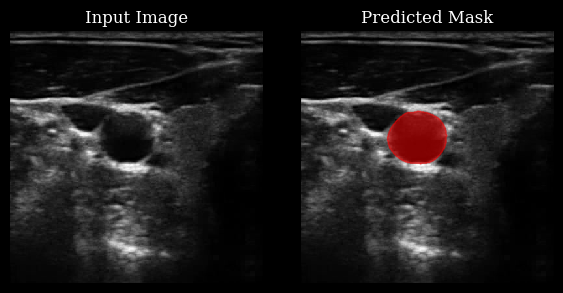

In [4]:
n_imgs = 1
url = "https://raw.githubusercontent.com/tue-bmd/zea/main/docs/source/notebooks/assets/carotid.png"

response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert("L")
img_np = np.asarray(img).astype(np.float32) / 255.0

img_np = img_np[None, ..., None]  # add batch and channel dimensions
batch = ops.convert_to_tensor(img_np)

masks = model(batch)
masks = ops.squeeze(masks, axis=-1)
masks_clipped = ops.where(masks > 0.5, 1, 0)
masks_clipped = ops.convert_to_numpy(masks_clipped)

# stack batch twice to get 2 rows
batch_stacked = ops.concatenate([batch, batch])

# Plot the original image and its mask side by side, with each row as an example
fig, axes = plt.subplots(n_imgs, 2, figsize=(6, 3 * n_imgs))
axes = np.atleast_2d(axes)

for ax_img, ax_mask, img_arr, mask_arr in zip(axes[:, 0], axes[:, 1], batch[..., 0], masks_clipped):
    ax_img.imshow(img_arr, cmap="gray", vmin=0, vmax=1)
    ax_img.set_title("Input Image")
    ax_img.axis("off")
    ax_mask.imshow(img_arr, cmap="gray", vmin=0, vmax=1)
    add_shape_from_mask(ax_mask, mask_arr, color="red", alpha=0.5)
    ax_mask.set_title("Predicted Mask")
    ax_mask.axis("off")

plt.tight_layout()
plt.show()